                                                onilne stock prediction

---



---



**importing modules**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import os

--- Configuration ---

In [6]:
print("\nTo proceed, please provide a CSV file containing historical stock data with at least a 'Date' and 'Close' column.")
filepath = input("Enter CSV file path: ").strip()


To proceed, please provide a CSV file containing historical stock data with at least a 'Date' and 'Close' column.
Enter CSV file path: sample_stock_data.csv


In [7]:
if not os.path.exists(filepath):
    raise FileNotFoundError("The provided file path does not exist. Please make sure the CSV file is accessible.")

 --- Load Data from CSV ---

In [8]:
data = pd.read_csv(filepath)

Ensure required columns exist

In [10]:
if 'Date' not in data.columns or 'Close' not in data.columns:
    raise ValueError("CSV must contain 'Date' and 'Close' columns.")

data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)

print("\nData loaded successfully!")
print(f"\nLast 5 rows of the data:")
print(data.tail())


Data loaded successfully!

Last 5 rows of the data:
         Date  Close
95 2024-04-05  197.5
96 2024-04-06  198.0
97 2024-04-07  198.5
98 2024-04-08  199.0
99 2024-04-09  199.5


--- Plot Closing Price ---

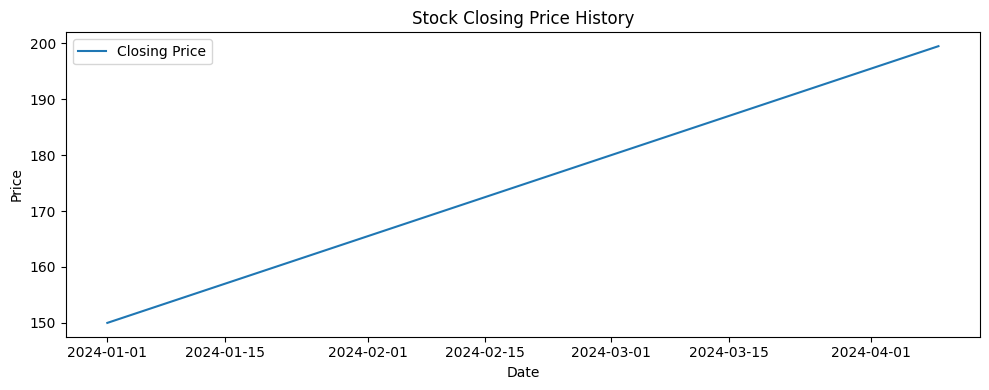

In [11]:
def plot_raw_data():
    plt.figure(figsize=(10, 4))
    plt.plot(data['Date'], data['Close'], label='Closing Price')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Stock Closing Price History")
    plt.legend()
    plt.tight_layout()
    plt.savefig("closing_price.png")
    plt.show()

plot_raw_data()

--- Prepare Data for LSTM ---

In [12]:
df = data[['Close']].copy()
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

train_size = int(len(df_scaled) * 0.80)
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

In [16]:
# Convert to sequences
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)

# Reduce time_step to a value smaller than the test data size
time_step = 10
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# --- Reshape for LSTM ---
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

 --- LSTM Model ---

In [17]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Train Model ---

In [18]:
print("\nTraining LSTM model... (this may take a minute)")
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

# --- Predict and Inverse Transform ---
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))


Training LSTM model... (this may take a minute)
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.2351
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1621
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1011
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0499
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0156
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 --- Plot Predictions ---

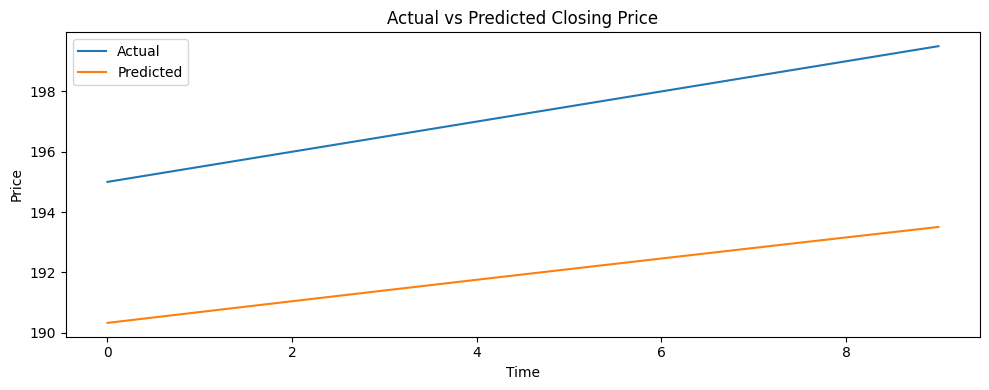

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_true, label="Actual")
plt.plot(test_predict, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs Predicted Closing Price")
plt.legend()
plt.tight_layout()
plt.savefig("actual_vs_predicted.png")
plt.show()

--- Forecast Next 30 Days ---


Forecasting next 30 days...


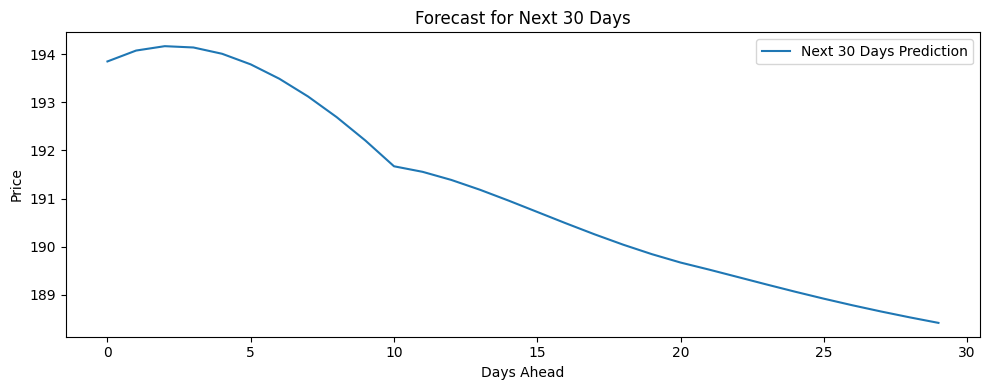

In [20]:
print("\nForecasting next 30 days...")
x_input = test_data[-time_step:].reshape(1, -1)
x_input = x_input[0].tolist()

future_preds = []
for _ in range(30):
    x = np.array(x_input[-time_step:]).reshape(1, time_step, 1)
    pred = model.predict(x, verbose=0)
    x_input.append(pred[0][0])
    future_preds.append(pred[0][0])

future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

plt.figure(figsize=(10, 4))
plt.plot(future_preds, label="Next 30 Days Prediction")
plt.xlabel("Days Ahead")
plt.ylabel("Price")
plt.title("Forecast for Next 30 Days")
plt.legend()
plt.tight_layout()
plt.savefig("forecast_30_days.png")
plt.show()